In [2]:
#ensemble VotingClassifier
import pandas as pd
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

cancer = load_breast_cancer()

data_df = pd.DataFrame(cancer.data, columns=cancer.feature_names)
data_df.head()

,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [15]:
#개별 모델은 LogisticRegression와 KNN
lr_clf = LogisticRegression()
knn_clf = KNeighborsClassifier(n_neighbors=8)

vo_clf = VotingClassifier(estimators=[('LR',lr_clf),('KNN',knn_clf)], voting='soft')

X_train,X_test,y_train,y_test = train_test_split(cancer.data,cancer.target,test_size=0.2,random_state=156)

#VotingClassifier 학습/예측/평가
vo_clf.fit(X_train,y_train)
pred = vo_clf.predict(X_test)
print('VotingClassifier 정확도: {0:.4f}'.format(accuracy_score(y_test,pred)))

#개별 모델의 학습/예측/평가
classifiers = [lr_clf,knn_clf]
for classifier in classifiers:
    classifier.fit(X_train,y_train)
    pred = classifier.predict(X_test)
    class_name = classifier.__class__.__name__
    print('{0} 정확도: {1:.4f}'.format(class_name,accuracy_score(y_test,pred)))

VotingClassifier 정확도: 0.9561
LogisticRegression 정확도: 0.9474
KNeighborsClassifier 정확도: 0.9386


In [19]:
#ensemble RandomForestClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import pandas as pd
import warnings
warnings.filterwarnings('ignore')


#중복되는 feature명 바꾸기
#https://www.kaggle.com/jinameliachoi/tutorial-human-activity-recognition-smartphone/notebook
def change_feature_name(old_feature_name_df):
    #cumcount는 cumalative하게 count, 
    #column_name에 있는 element가 몇번째로 중복이 되었는지 숫자로 반환
    #0번 중복되면 0
    feature_duplicate_df = pd.DataFrame(data=old_feature_name_df.groupby('column_name').cumcount(),columns=['dup_cnt'])
    #index 기본형으로 reset, column_name은 옆으로 밀려남
    feature_duplicate_df = feature_duplicate_df.reset_index()
    new_feature_name_df = pd.merge(old_feature_name_df.reset_index(),feature_duplicate_df,how='outer')
    #changing name and changing the elements in column_name
    new_feature_name_df['column_name'] = new_feature_name_df[['column_name','dup_cnt']].apply(lambda x: x[0]+'_'+str(x[1]) if x[1]>0 else x[0], axis=1)
    #drop index
    new_feature_name_df = new_feature_name_df.drop(['index'],axis=1)
    
    return new_feature_name_df

def get_human_dataset():
    
    #각 data file들은 공백으로 분리가 되어있으므로 공백 문자를 sep으로 할당
    feature_name_df = pd.read_csv('./human_activity/features.txt',sep='\s+',header=None,names=['column_index','column_name'])

    #change_feature_name 적용
    feature_name_df = change_feature_name(feature_name_df)
    #DataFrame에 feature name을 column으로 부여하기 위해 list 객체로 다시 변환
    feature_name = feature_name_df.iloc[:,1].values.tolist()
    
    #train feature dataset와 test feature dataset를 DataFrame으로 로딩
    X_train = pd.read_csv('./human_activity/train/X_train.txt',sep='\s+',names=feature_name)
    X_test = pd.read_csv('./human_activity/test/X_test.txt',sep='\s+',names=feature_name)
    
    #train label과 test label data를 DataFrame으로 로딩하고 column name은 action으로 부여
    y_train = pd.read_csv('./human_activity/train/y_train.txt',sep='\s+', \
                          header=None,names=['action'])
    y_test = pd.read_csv('./human_activity/test/y_test.txt',sep='\s+', \
                          header=None,names=['action'])
    
    #로드된 학습/테스트용 DataFrame을 모두 반환
    return X_train,X_test,y_train,y_test


#DecisionTree에서 사용한 get_human_dataset()을 이용해 학습/테스트용 DataFrame 반환
X_train,X_test,y_train,y_test = get_human_dataset()

#RandomForest 예측 성능 평가
rf_clf = RandomForestClassifier(random_state=0)
rf_clf.fit(X_train,y_train)
pred = rf_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)
print('RandomForest 정확도: {0:.4f}'.format(accuracy))


RandomForest 정확도: 0.9108


In [17]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators':[100],
    'max_depth': [6,8,10,12],
    'min_samples_leaf': [8,12,18],
    'min_samples_split': [8,16,20]
}

rf_clf = RandomForestClassifier(random_state=0,n_jobs=-1)
grid_cv = GridSearchCV(rf_clf,param_grid=params,cv=2,n_jobs=-1)
grid_cv.fit(X_train,y_train)

print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))


최적 하이퍼 파라미터:
 {'max_depth': 6, 'min_samples_leaf': 8, 'min_samples_split': 8, 'n_estimators': 100}
최고 예측 정확도: 0.9451


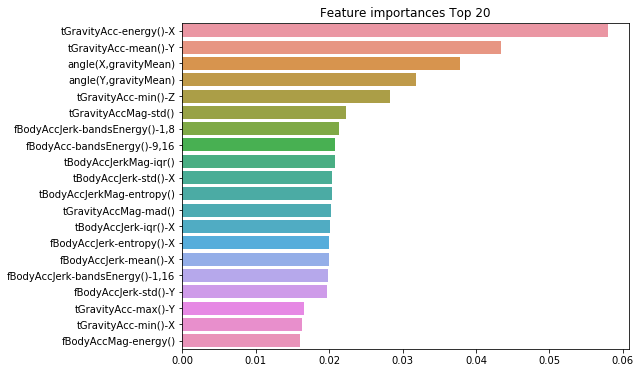

In [21]:
#feature 중요도 막대그래프
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
ftr_importances_values = rf_clf.feature_importances_
ftr_importances = pd.Series(ftr_importances_values,index=X_train.columns)
ftr_top20 = ftr_importances.sort_values(ascending=False)[:20]

plt.figure(figsize=(8,6))
plt.title('Feature importances Top 20')
sns.barplot(x=ftr_top20,y=ftr_top20.index)
plt.show()

In [24]:
#GBM(Gradient Boosting Machine)
from sklearn.ensemble import GradientBoostingClassifier
import time
import warnings
warnings.filterwarnings('ignore')

X_train,X_test,y_train,y_test = get_human_dataset()

#GBM 수행 시간 측정을 위함. 시작 시간 설정
start_time = time.time()
gb_clf = GradientBoostingClassifier(random_state=0)
gb_clf.fit(X_train,y_train)
pred = gb_clf.predict(X_test)
accuracy = accuracy_score(y_test,pred)

print('GBM accuracy: {0:.4f}'.format(accuracy))
print('GBM 수행 시간: {0:.4f}초'.format(time.time()-start_time))


GBM accuracy: 0.9386
GBM 수행 시간: 168.7830초


In [ ]:
from sklearn.model_selection import GridSearchCV

params = {
    'n_estimators': [100,500],
    'learning_rate': [0.05,0.1]
}
grid_cv = GridSearchCV(gb_clf,param_grid=params,cv=2,verbose=1)
#30분에서 1시간 걸린다 함
grid_cv.fit(X_train,y_train)
print('최적 하이퍼 파라미터:\n',grid_cv.best_params_)
print('최고 예측 정확도: {0:.4f}'.format(grid_cv.best_score_))

#test set에 최적으로 학습된 estimator 적용
gb_pred = grid_cv.best_estimator_.predict(X_test)
gb_accuracy = accuracy_score(y_test,gb_pred)
print('GBM accuracy: {0:.4f}'.format(gb_accuracy))


In [31]:
#파이썬 래퍼 XGBoost
import xgboost as xgb
from xgboost import plot_importance
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split
import warnings
warnings.filterwarnings('ignore')

dataset = load_breast_cancer()
X_features = dataset.data
y_label = dataset.target
cancer_df = pd.DataFrame(data=X_features,columns=dataset.feature_names)
cancer_df['target']=y_label
cancer_df.head()


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension,target
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890,0
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902,0
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758,0
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300,0
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678,0


In [32]:
print(dataset.target_names)
print(cancer_df['target'].value_counts())

['malignant' 'benign']
1    357
0    212
Name: target, dtype: int64


In [39]:
X_train,X_test,y_train,y_test = train_test_split(X_features,y_label,test_size=0.2,random_state=156)
print(X_train.shape,X_test.shape)

dtrain = xgb.DMatrix(data=X_train,label=y_train)
dtest = xgb.DMatrix(data=X_test,label=y_test)


(455, 30) (114, 30)


In [41]:
#학습
params = {'max_depth': 3,
         'eta': 0.1,
          'objective': 'binary:logistic',
          'eval_metric': 'logloss',
          'early_stoppings': 100
         }
num_rounds = 400

#train 데이터 세트 'train', evaluation(test) 데이터 세트는 'eval'로 명기합니다
wlist = [(dtrain,'train'),(dtest,'eval')]
#하이퍼 파라미터 early stopping 파라미터를 train() 함수의 파라미터로 전달
xgb_model = xgb.train(params=params,dtrain=dtrain,num_boost_round=num_rounds,evals=wlist)


[0]	train-logloss:0.609688	eval-logloss:0.61352
[1]	train-logloss:0.540803	eval-logloss:0.547842
[2]	train-logloss:0.483753	eval-logloss:0.494247
[3]	train-logloss:0.434457	eval-logloss:0.447986
[4]	train-logloss:0.39055	eval-logloss:0.409109
[5]	train-logloss:0.354145	eval-logloss:0.374977
[6]	train-logloss:0.321222	eval-logloss:0.345714
[7]	train-logloss:0.292593	eval-logloss:0.320529
[8]	train-logloss:0.267467	eval-logloss:0.29721
[9]	train-logloss:0.245153	eval-logloss:0.277991
[10]	train-logloss:0.225694	eval-logloss:0.260302
[11]	train-logloss:0.207937	eval-logloss:0.246037
[12]	train-logloss:0.192184	eval-logloss:0.231556
[13]	train-logloss:0.177916	eval-logloss:0.22005
[14]	train-logloss:0.165222	eval-logloss:0.208572
[15]	train-logloss:0.153622	eval-logloss:0.199993
[16]	train-logloss:0.14333	eval-logloss:0.190118
[17]	train-logloss:0.133985	eval-logloss:0.181818
[18]	train-logloss:0.125599	eval-logloss:0.174729
[19]	train-logloss:0.117286	eval-logloss:0.167657
[20]	train-logl

[164]	train-logloss:0.0072	eval-logloss:0.087777
[165]	train-logloss:0.00718	eval-logloss:0.087517
[166]	train-logloss:0.007161	eval-logloss:0.087542
[167]	train-logloss:0.007142	eval-logloss:0.087642
[168]	train-logloss:0.007122	eval-logloss:0.08739
[169]	train-logloss:0.007103	eval-logloss:0.087377
[170]	train-logloss:0.007084	eval-logloss:0.087298
[171]	train-logloss:0.007065	eval-logloss:0.087368
[172]	train-logloss:0.007047	eval-logloss:0.087395
[173]	train-logloss:0.007028	eval-logloss:0.087385
[174]	train-logloss:0.007009	eval-logloss:0.087132
[175]	train-logloss:0.006991	eval-logloss:0.087159
[176]	train-logloss:0.006973	eval-logloss:0.086955
[177]	train-logloss:0.006955	eval-logloss:0.087053
[178]	train-logloss:0.006937	eval-logloss:0.08697
[179]	train-logloss:0.00692	eval-logloss:0.086973
[180]	train-logloss:0.006901	eval-logloss:0.087038
[181]	train-logloss:0.006884	eval-logloss:0.086799
[182]	train-logloss:0.006866	eval-logloss:0.086826
[183]	train-logloss:0.006849	eval-log

[326]	train-logloss:0.005354	eval-logloss:0.08578
[327]	train-logloss:0.005348	eval-logloss:0.085857
[328]	train-logloss:0.005342	eval-logloss:0.085939
[329]	train-logloss:0.005336	eval-logloss:0.085825
[330]	train-logloss:0.00533	eval-logloss:0.085869
[331]	train-logloss:0.005324	eval-logloss:0.085893
[332]	train-logloss:0.005318	eval-logloss:0.085922
[333]	train-logloss:0.005312	eval-logloss:0.085842
[334]	train-logloss:0.005306	eval-logloss:0.085735
[335]	train-logloss:0.0053	eval-logloss:0.085816
[336]	train-logloss:0.005294	eval-logloss:0.085892
[337]	train-logloss:0.005288	eval-logloss:0.085936
[338]	train-logloss:0.005283	eval-logloss:0.08583
[339]	train-logloss:0.005277	eval-logloss:0.085909
[340]	train-logloss:0.005271	eval-logloss:0.085831
[341]	train-logloss:0.005265	eval-logloss:0.085727
[342]	train-logloss:0.00526	eval-logloss:0.085678
[343]	train-logloss:0.005254	eval-logloss:0.085721
[344]	train-logloss:0.005249	eval-logloss:0.085796
[345]	train-logloss:0.005243	eval-log

In [43]:
#예측
pred_probs = xgb_model.predict(dtest)
print('predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨')
print(np.round(pred_probs[:10],3))

#예측 확률이 0.5보다 크면 1, 그렇지 않으면 0으로 예측값 결정해 list 객체인 preds에 저장
preds = [1 if x>0.5 else 0 for x in pred_probs]
print('예측값 10개만 표시:',preds[:10])


predict() 수행 결괏값을 10개만 표시, 예측 확률값으로 표시됨
[0.95  0.003 0.9   0.086 0.993 1.    1.    0.999 0.998 0.   ]
예측값 10개만 표시: [1, 0, 1, 0, 1, 1, 1, 1, 1, 0]


In [47]:
#평가
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score,precision_score,recall_score,roc_auc_score
from sklearn.metrics import f1_score,confusion_matrix,precision_recall_curve,roc_curve
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression

def get_clf_eval(y_test,pred):
    confusion = confusion_matrix(y_test,pred)
    accuracy = accuracy_score(y_test,pred)
    precision = precision_score(y_test,pred)
    recall = recall_score(y_test,pred)
    f1 = f1_score(y_test,pred)
    auc = roc_auc_score(y_test,pred)
    print('confusion matrix')
    print(confusion)
    print('accuracy: {0:.4f}, precision: {1:.4f}, recall: {2:.4f}, f1: {3:.4f}, AUC: {4:.4f}'.format(accuracy,precision,recall,f1,auc))

get_clf_eval(y_test,preds)

confusion matrix
[[35  2]
 [ 1 76]]
accuracy: 0.9737, precision: 0.9744, recall: 0.9870, f1: 0.9806, AUC: 0.9665


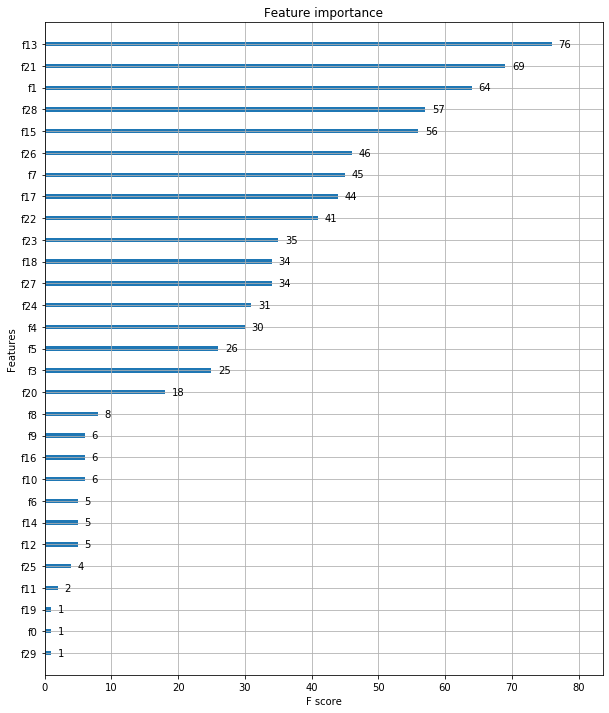

In [48]:
#시각화 plot_importance()
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

#matplolib ax객체도 입력
fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_model,ax=ax)


In [50]:
#사이킷런 래퍼 XGBoost
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)
xgb_wrapper.fit(X_train,y_train)
w_preds = xgb_wrapper.predict(X_test)

get_clf_eval(y_test,w_preds)


confusion matrix
[[35  2]
 [ 1 76]]
accuracy: 0.9737, precision: 0.9744, recall: 0.9870, f1: 0.9806, AUC: 0.9665


In [51]:
#조기 중단 수행
from xgboost import XGBClassifier

xgb_wrapper = XGBClassifier(n_estimators=400,learning_rate=0.1,max_depth=3)

evals = [(X_test,y_test)]
xgb_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)
ws100_preds = xgb_wrapper.predict(X_test)


[0]	validation_0-logloss:0.61352
Will train until validation_0-logloss hasn't improved in 100 rounds.
[1]	validation_0-logloss:0.547842
[2]	validation_0-logloss:0.494247
[3]	validation_0-logloss:0.447986
[4]	validation_0-logloss:0.409109
[5]	validation_0-logloss:0.374977
[6]	validation_0-logloss:0.345714
[7]	validation_0-logloss:0.320529
[8]	validation_0-logloss:0.29721
[9]	validation_0-logloss:0.277991
[10]	validation_0-logloss:0.260302
[11]	validation_0-logloss:0.246037
[12]	validation_0-logloss:0.231556
[13]	validation_0-logloss:0.22005
[14]	validation_0-logloss:0.208572
[15]	validation_0-logloss:0.199993
[16]	validation_0-logloss:0.190118
[17]	validation_0-logloss:0.181818
[18]	validation_0-logloss:0.174729
[19]	validation_0-logloss:0.167657
[20]	validation_0-logloss:0.158202
[21]	validation_0-logloss:0.154725
[22]	validation_0-logloss:0.148947
[23]	validation_0-logloss:0.143308
[24]	validation_0-logloss:0.136344
[25]	validation_0-logloss:0.132778
[26]	validation_0-logloss:0.127912

[230]	validation_0-logloss:0.086002
[231]	validation_0-logloss:0.085922
[232]	validation_0-logloss:0.086102
[233]	validation_0-logloss:0.086115
[234]	validation_0-logloss:0.086169
[235]	validation_0-logloss:0.086263
[236]	validation_0-logloss:0.086292
[237]	validation_0-logloss:0.086217
[238]	validation_0-logloss:0.086395
[239]	validation_0-logloss:0.086342
[240]	validation_0-logloss:0.08618
[241]	validation_0-logloss:0.086195
[242]	validation_0-logloss:0.086248
[243]	validation_0-logloss:0.086263
[244]	validation_0-logloss:0.086293
[245]	validation_0-logloss:0.086222
[246]	validation_0-logloss:0.086398
[247]	validation_0-logloss:0.086347
[248]	validation_0-logloss:0.086276
[249]	validation_0-logloss:0.086448
[250]	validation_0-logloss:0.086294
[251]	validation_0-logloss:0.086312
[252]	validation_0-logloss:0.086364
[253]	validation_0-logloss:0.086394
[254]	validation_0-logloss:0.08649
[255]	validation_0-logloss:0.086441
[256]	validation_0-logloss:0.08629
[257]	validation_0-logloss:0.08

In [52]:
get_clf_eval(y_test,ws100_preds)

confusion matrix
[[34  3]
 [ 1 76]]
accuracy: 0.9649, precision: 0.9620, recall: 0.9870, f1: 0.9744, AUC: 0.9530


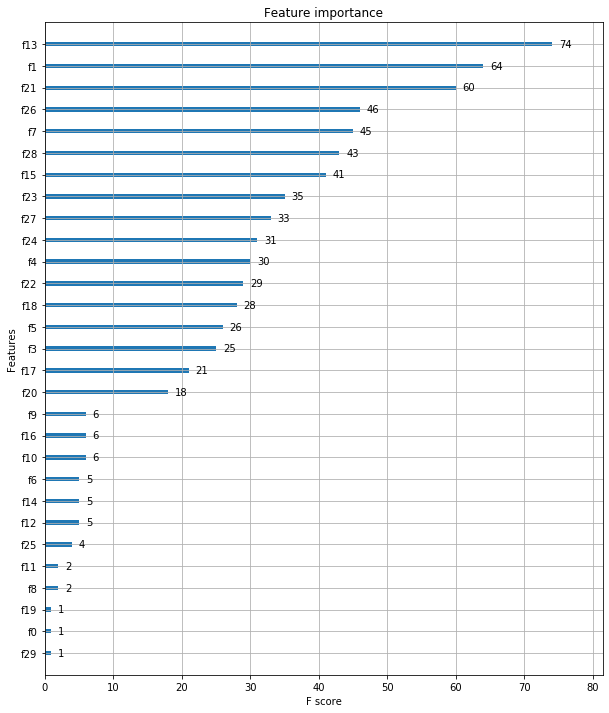

In [53]:
#사이킷런 래퍼 클래스에도 plot_importance 적용 가능
from xgboost import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(xgb_wrapper,ax=ax)


In [55]:
#LightGBM
from lightgbm import LGBMClassifier
import pandas as pd
import numpy as np
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

dataset = load_breast_cancer()
ftr = dataset.data
target = dataset.target

X_train,X_test,y_train,y_test = train_test_split(ftr,target,test_size=0.2,random_state=156)

lgbm_wrapper = LGBMClassifier(n_estimators=400)

#조기중단 가능
evals = [(X_test,y_test)]
lgbm_wrapper.fit(X_train,y_train,early_stopping_rounds=100,eval_metric='logloss',eval_set=evals,verbose=True)
preds = lgbm_wrapper.predict(X_test)


[1]	valid_0's binary_logloss: 0.565079
Training until validation scores don't improve for 100 rounds
[2]	valid_0's binary_logloss: 0.507451
[3]	valid_0's binary_logloss: 0.458489
[4]	valid_0's binary_logloss: 0.417481
[5]	valid_0's binary_logloss: 0.385507
[6]	valid_0's binary_logloss: 0.355846
[7]	valid_0's binary_logloss: 0.330897
[8]	valid_0's binary_logloss: 0.306923
[9]	valid_0's binary_logloss: 0.28776
[10]	valid_0's binary_logloss: 0.26917
[11]	valid_0's binary_logloss: 0.250954
[12]	valid_0's binary_logloss: 0.23847
[13]	valid_0's binary_logloss: 0.225865
[14]	valid_0's binary_logloss: 0.215076
[15]	valid_0's binary_logloss: 0.205996
[16]	valid_0's binary_logloss: 0.196091
[17]	valid_0's binary_logloss: 0.186395
[18]	valid_0's binary_logloss: 0.17942
[19]	valid_0's binary_logloss: 0.174727
[20]	valid_0's binary_logloss: 0.168563
[21]	valid_0's binary_logloss: 0.165432
[22]	valid_0's binary_logloss: 0.160356
[23]	valid_0's binary_logloss: 0.155508
[24]	valid_0's binary_logloss: 

In [56]:
get_clf_eval(y_test,preds)


confusion matrix
[[33  4]
 [ 2 75]]
accuracy: 0.9474, precision: 0.9494, recall: 0.9740, f1: 0.9615, AUC: 0.9330


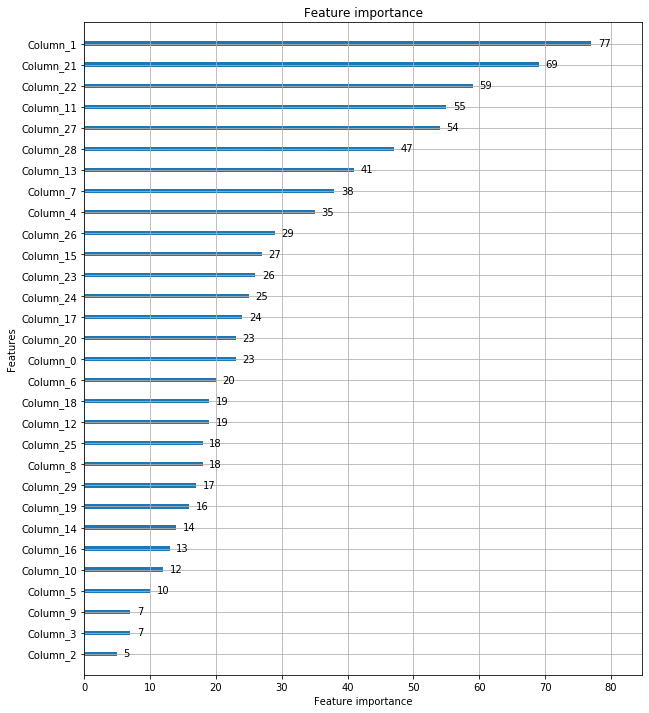

In [57]:
#시각화 파이썬 패키지 lightgbm의 plot_importance 사용
from lightgbm import plot_importance
import matplotlib.pyplot as plt
%matplotlib inline

fig,ax = plt.subplots(figsize=(10,12))
plot_importance(lgbm_wrapper, ax=ax)
